In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torch.jit
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from torch import Tensor
import torch.optim as optim

from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 16

trainset = torchvision.datasets.ImageFolder(root='cat-vs-dog-data/training_set/training_set', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='cat-vs-dog-data/test_set/test_set/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('cat', 'dog')

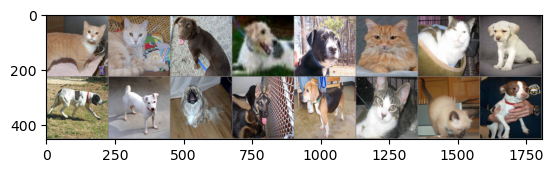

cat   cat   dog   dog   dog   cat   cat   dog   dog   dog   dog   dog   dog   cat   cat   dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
def totParamCounter(net: nn.Module) -> int:
    return sum(param.numel() for param in net.parameters())

In [5]:
device = torch.device('mps')

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 53 * 53, 2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

In [7]:
net = SimpleNet().to(device=device)
print(net)
print(totParamCounter(net))

SimpleNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=2, bias=True)
)
413250


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), 0.1)

In [9]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs, labels = inputs.to(torch.device('mps')), labels.to(torch.device('mps'))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / 4000:.3f}')

print('Finished Training')

100%|██████████| 501/501 [01:00<00:00,  8.32it/s]


[1] loss: 0.105


100%|██████████| 501/501 [01:00<00:00,  8.28it/s]


[2] loss: 0.088


100%|██████████| 501/501 [01:02<00:00,  8.07it/s]


[3] loss: 0.088


100%|██████████| 501/501 [01:02<00:00,  8.03it/s]


[4] loss: 0.088


100%|██████████| 501/501 [01:02<00:00,  8.07it/s]

[5] loss: 0.088
Finished Training
